In [188]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from numba import jit, int32, float64
from tqdm import tqdm

from math import cos, sin, exp
%matplotlib inline
np.random.seed(500)

### Случайные ошибки как квантовый процесс


In [189]:
def UnitaryTransformation(delta, tetta, phi):
    R = np.array([[np.cos(delta/2)-1j*np.cos(tetta)*np.sin(delta/2), -1j*np.sin(tetta)*np.sin(delta/2)*np.exp(-1j*phi)],
                 [-1j*np.sin(tetta)*np.sin(delta/2)*np.exp(1j*phi), np.cos(delta/2)+1j*np.cos(tetta)*np.sin(delta/2)]], dtype=np.complex64)
    return R

In [251]:
# задаём параметры
d = 2 
e = 0
delta = e*np.pi/10
tetta = np.pi/4
phi = np.pi
R = UnitaryTransformation(delta, tetta, phi)

In [254]:
# готовим чистое состояние
pure_state = np.array([np.random.normal(0, 1, d) + 1j*np.random.normal(0, 1, d)])[0]
pure_state /= np.linalg.norm(pure_state)

In [255]:
pure_state

array([ 0.24608978+0.63884495j, -0.12275065-0.71850486j])

In [256]:
# применяем унитарное преобразование
pure_state_transformed = np.dot(R, pure_state)

In [257]:
np.linalg.norm(pure_state_transformed)

1.0000000000000002

In [263]:
# определим реализацию эксперимента Бернулли
n_iter = 1000
#@jit(float64(int32), parallel=True)
def Experiment(n_iter, e):
    '''
    test Bernulli experiment for Unitary evolution with quantum noise
    '''
    delta_arr = e*np.pi/10
    R_arr = UnitaryTransformation(delta_arr, tetta, phi)

    zero_state = np.array([1,0])
    p = []

    for i in range(n_iter):
        transformed_state = np.dot(R_arr[:,:,i], pure_state)
        p_i = np.abs(np.vdot(zero_state, transformed_state))**2
        p.append(p_i)

    Bernulli_result = np.random.binomial(1, p)
    k = Bernulli_result[Bernulli_result==1].shape[0]
    prob_1 = k/n_iter
    
    return prob_1

In [278]:
%%time
N = 10000
e = np.random.uniform(low=-0.2, high=0.1, size=n_iter)
prob_1_arr=[]

for i in tqdm(range(N)):
    prob_1 = Experiment(n_iter, e)
    prob_1_arr.append(prob_1)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:17<00:00, 129.15it/s]

Wall time: 1min 17s


In [279]:
%%time
N = 10000
e = np.zeros(n_iter)
prob_2_arr=[]

for i in tqdm(range(N)):
    prob_2 = Experiment(n_iter, e)
    prob_2_arr.append(prob_2)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:13<00:00, 136.34it/s]

Wall time: 1min 13s


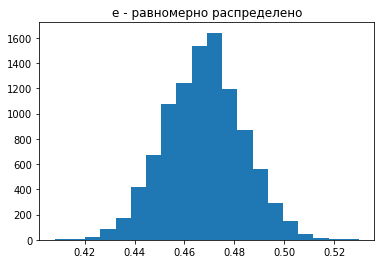

In [280]:
plt.hist(prob_1_arr, bins=20)
plt.title('e - равномерно распределено')
plt.show()

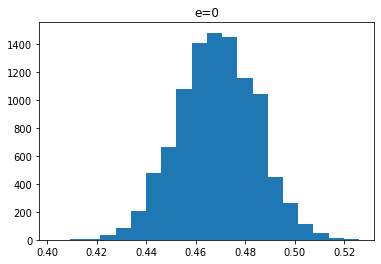

In [281]:
plt.hist(prob_2_arr, bins=20)
plt.title('e=0')
plt.show()

In [271]:
def Craus(rho_in, E):
    rho_out = np.zeros_like(rho_in)
    
    for j in range(len(E)):
        rho_out += E[j] @ rho_in @ E[j].T.conj()
            
    return rho_out

identity = np.array([[1,0],
                    [0,1]])

In [272]:
e = np.random.uniform(low=-0.2, high=0.1, size=1)
delta = e*np.pi/10
R = UnitaryTransformation(delta, tetta, phi)[:,:,0]

In [273]:
R

array([[ 9.9989128e-01-0.01042703j, -1.2769424e-18+0.01042703j],
       [ 1.2769424e-18+0.01042703j,  9.9989128e-01+0.01042703j]],
      dtype=complex64)

In [274]:
# вычисляем матрицу xi
Psi = 1/np.sqrt(2)*np.array([1.,0.,0.,1.], dtype=np.complex64)
bell_rho = np.outer(Psi, Psi.conj())

E_extend = [np.kron(identity, R)]

xi_2 = 2*Craus(bell_rho, E_extend)
xi_2

array([[ 9.9989122e-01+0.0000000e+00j, -1.0872287e-04-1.0425892e-02j,
        -1.0872287e-04-1.0425892e-02j,  9.9967378e-01-2.0851783e-02j],
       [-1.0872287e-04+1.0425892e-02j,  1.0872287e-04+0.0000000e+00j,
         1.0872287e-04-2.6629422e-20j,  1.0872287e-04+1.0425892e-02j],
       [-1.0872287e-04+1.0425892e-02j,  1.0872287e-04+2.6629422e-20j,
         1.0872287e-04+0.0000000e+00j,  1.0872287e-04+1.0425892e-02j],
       [ 9.9967378e-01+2.0851783e-02j,  1.0872287e-04-1.0425892e-02j,
         1.0872287e-04-1.0425892e-02j,  9.9989122e-01+0.0000000e+00j]],
      dtype=complex64)

In [275]:
# вычисляем операторы Крауса
W, V = np.linalg.eig(xi_2) 
e_matrix = V@np.diag(np.sqrt(W))
s = e_matrix.shape[0]

E_craus = []
for i in range(s):
    E_craus.append(e_matrix[:,i].reshape(s//2, s//2))

In [276]:
rho_in = np.outer(pure_state, pure_state.conj())
rho_out = Craus(rho_in, E_craus)
rho_out

array([[ 0.47084796-2.44546881e-29j, -0.4870559 +1.09209415e-01j],
       [-0.4870559 -1.09209415e-01j,  0.52915201-3.46944695e-18j]])

In [277]:
zero_state = np.array([1,0])
p_e = np.dot(zero_state, np.dot(rho_out, zero_state))
print(p_e.real)

0.4708479621265103


Как видно, вероятность попадает в обрасть нормального распределения (сформированного на первой гистограмме) 

### Зашумлённые квантовые схемы

In [166]:
I = np.identity(2, dtype=np.complex128)
H = 1/np.sqrt(2)*np.array([[1, 1],
             [1, -1]])

def R_m(m):
    return np.array([[1, 0],
                     [0, np.exp(1j*2*np.pi/2**m)]],dtype=np.complex64)

In [143]:
n = 8
delta = np.pi/10
tetta = np.pi/4
phi = np.pi

In [144]:
# другой способ на основе построения матрицы QFT

def U(e):
    ksi = e*np.random.uniform(low=-0.1, high=0.1)
    U_noise = UnitaryTransformation(ksi*delta, tetta, phi)
    return U_noise

def qubit_matrix(U, pos=1, n_qubits=2):
    '''
    return matrin of single qubit @U when count of qubits = @n_qubits
    '''
    U_res = 1
    for i in range(n_qubits):
        if i == pos:
            U_res = np.kron(U_res, U)
        else:
            U_res = np.kron(U_res, I)
    return U_res

def control_U(U, n_qubits, c_pos, t_pos):
    c_U = np.identity(2**n_qubits, dtype=np.complex128)
    pos0 = 2**(n_qubits - c_pos - 1)
    pos1 = 2**(n_qubits - c_pos - 1) + 2**(n_qubits - t_pos-1)
    c_U[pos0][pos0] = U[0,0]
    c_U[pos0][pos1] = U[0,1]
    c_U[pos1][pos0] = U[1,0]
    c_U[pos1][pos1] = U[1,1]
    
    return c_U

def QFT(n_qubits):
    QFT_matrix = np.identity(2**n_qubits, dtype=np.complex128)
    
    for layer in range(n_qubits):
        QFT_matrix = QFT_matrix @ qubit_matrix(H, pos=layer, n_qubits=n_qubits)
        for m in range(1, n_qubits - layer):
            rotation = control_U(R_m(m+1), n_qubits=n_qubits, c_pos=m+layer, t_pos=layer)
            QFT_matrix = np.dot(QFT_matrix, rotation)
    return QFT_matrix

def noisy_QFT(n_qubits, e):
    QFT_matrix = np.identity(2**n_qubits, dtype=np.complex128)
    
    for layer in range(n_qubits):
        H_noisy = np.dot(H, U(e))
        
        QFT_matrix = QFT_matrix @ qubit_matrix(H_noisy, pos=layer, n_qubits=n_qubits)
        for m in range(1, n_qubits - layer):
            rotation = control_U(R_m(m+1)@U(e), n_qubits=n_qubits, c_pos=m+layer, t_pos=layer)
            QFT_matrix = np.dot(QFT_matrix, rotation)
    return QFT_matrix

In [145]:
# готовим чистое состояние
psi = np.array([np.random.normal(0, 1, 2**n) + 1j*np.random.normal(0, 1, 2**n)])[0]
psi /= np.linalg.norm(psi)

In [146]:
# незашумлённое QFT
phi0 = np.dot(QFT(n), psi)

In [147]:
phi_i = np.dot(noizy_QFT(n, e_i), psi)
np.linalg.norm(phi_i)

1.000000007266417

In [148]:
%time
n_iter = 100
e_arr = [0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
F = []


for e_i in e_arr:
    print(f'Cicle for {e_i}')
    F_aver = 0
    for i in tqdm(range(n_iter)):
        phi_i = np.dot(noisy_QFT(n, e_i), psi)
        F_aver += np.abs(np.vdot(phi0, phi_i))**2
    F_aver /= n_iter
    F.append(F_aver)

Wall time: 0 ns
Cicle for 0


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.52it/s]


Cicle for 0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.79it/s]


Cicle for 0.0005


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.76it/s]


Cicle for 0.001


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.66it/s]


Cicle for 0.005


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.72it/s]


Cicle for 0.01


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.64it/s]


Cicle for 0.05


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.72it/s]


Cicle for 0.1


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.75it/s]


Text(0, 0.5, 'Средняя точность F')

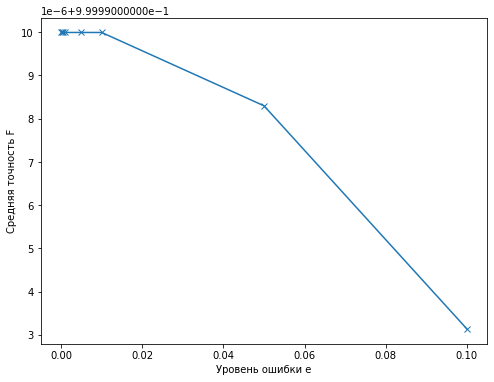

In [165]:
plt.figure(figsize=(8,6))
plt.plot(e_arr, F, '-x')
plt.xlabel("Уровень ошибки e")
plt.ylabel("Средняя точность F")
#plt.ylim(0,1)

Поскольку в моём варианте $\delta = e\frac{\pi}{10}$ (типичный порядок 1e-5 -- 1e-6), то матрица шума оказывается близкой к единице и влияние шума оказывается малым. Если значительно увеличить, порядок e, то и падение Фиделити станостится заметным

### Другой метод, но который не сработал

Идея реализации QFT: 

1) Раскладываем входное состояние psi по базису |j>.

2) Для каждого базисного состояния вычисляем QFT, представляя j в бинарном виде j1 j2 j3...jn 

3) Сосбираем всё в единую сумму с соответствующими компонентами |psi> 

In [471]:
def basis_state_array(state='000'):
    '''
    Convers qubit-ket notation state to numpy array of 2D vector
    @state - string, consisted of '0' or '1' like '001'
    '''
    zero_state = np.array([1,0])
    one_state = np.array([0,1])
    basis_1D = [zero_state, one_state]
    
    for i in range(len(state)):
        if (i==0):
            res = [basis_1D[int(state[i])]]
            continue
        res.append(basis_1D[int(state[i])])
        
    return res
                            
def QFT_basis(str_psi):
    '''@str_psi like 000100'''
    psi_logic = basis_state_array(str_psi)
    n = len(psi_logic)
    
    for j in range(n):
        psi_logic[j] = np.dot(H, psi_logic[j])
        
        for i in range(1, n-j):
            R = int(str_psi[i])*R_m(i+1) + (1-int(str_psi[i]))*I
            psi_logic[j] = np.dot(R, psi_logic[j])
    
    qft_psi = psi_logic[0]
    for i in range(1, n):
        qft_psi = np.kron(qft_psi, psi_logic[i])
            
    return qft_psi

def QFT_basis_with_noise(str_psi, e=0):
    '''@str_psi like 000100'''
    psi_logic = basis_state_array(str_psi)
    n = len(psi_logic)
    
    for j in range(n):
        ksi = e*np.random.uniform(low=-0.1, high=0.1)
        U_noise = UnitaryTransformation(ksi*delta, tetta, phi)
        
        psi_logic[j] = np.dot(np.dot(H, U_noise), psi_logic[j])
        
        for i in range(1, n-j):
            ksi = e*np.random.uniform(low=-0.1, high=0.1)
            #U_noise = UnitaryTransformation(ksi*delta, tetta, phi)
            U_noise = I
            
            if int(str_psi[i]):
                R = np.dot(R_m(i+1), U_noise)
            else:
                R = I.copy()
            #R = int(str_psi[i])*np.dot(R_m(i+1), U_noise) + (1-int(str_psi[i]))*I
            psi_logic[j] = np.dot(R, psi_logic[j])
    
    qft_psi = psi_logic[0]
    for i in range(1, n):
        qft_psi = np.kron(qft_psi, psi_logic[i])
            
    return qft_psi

In [457]:
n = 8
delta = np.pi/10
tetta = np.pi/4
phi = np.pi

# генерируем базис в строковом формате
str_basis = [bin(i)[3:] for i in range(2**n, 2**(n+1))]
str_basis[:3]

['000', '001', '010']

In [458]:
QFT_basis_vectors = [QFT_basis(s) for s in str_basis]

In [459]:
%%time
x = QFT(n, psi, with_noise=True, e=0.1)
x[10]

IndexError: index 10 is out of bounds for axis 0 with size 8

In [444]:
x = QFT(n, psi, with_noise=False)
np.linalg.norm(x)

1.093199787188026

In [445]:
# готовим чистое состояние
psi = np.array([np.random.normal(0, 1, 2**n) + 1j*np.random.normal(0, 1, 2**n)])[0]
psi /= np.linalg.norm(psi)

In [446]:
# QFT
QFT_psi = np.zeros_like(psi)
for i in range(psi.shape[0]):
    QFT_psi += psi[i]*QFT_basis_vectors[i]

In [447]:
np.linalg.norm(QFT_psi)

0.8507582988901132

Соберём теперь всё в одну функцию

In [460]:
def QFT(n, psi, with_noise=False, e=0):
    assert psi.shape[0] == 2**n, "Error: dimensions doesn't match"
    
    str_basis = [bin(i)[3:] for i in range(2**n, 2**(n+1))]
    
    if with_noise:
        QFT_basis_vectors = [QFT_basis_with_noise(s, e) for s in str_basis]
    else:
        QFT_basis_vectors = [QFT_basis(s) for s in str_basis]
    
    QFT_psi = np.zeros_like(psi)
    for i in range(psi.shape[0]):
        QFT_psi += psi[i]*QFT_basis_vectors[i]
    
    return QFT_psi

In [461]:
# незашумлённое QFT
phi0 = QFT(n, psi)

In [462]:
%%time
str_basis = [bin(i)[3:] for i in range(2**n, 2**(n+1))]
x =  [QFT_basis_with_noise(s, e) for s in str_basis]

ValueError: shapes (2,2,1) and (2,) not aligned: 1 (dim 2) != 2 (dim 0)

In [463]:
%time
n_iter = 10
e_arr = [0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
F = []


for e_i in e_arr:
    print(f'Cicle for {e_i}')
    F_aver = 0
    for i in tqdm(range(n_iter)):
        phi_i = QFT(n, psi, with_noise=True, e=e_i)
        F_aver += np.abs(np.vdot(phi0, phi_i))**2
    F_aver /= n_iter
    F.append(F_aver)

Wall time: 0 ns
Cicle for 0


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 445.15it/s]


Cicle for 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 536.46it/s]


Cicle for 0.0005


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 261.13it/s]


Cicle for 0.001


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 577.94it/s]


Cicle for 0.005


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 397.29it/s]


Cicle for 0.01


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 393.52it/s]


Cicle for 0.05


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 416.62it/s]


Cicle for 0.1


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 300.35it/s]


(0.0, 1.0)

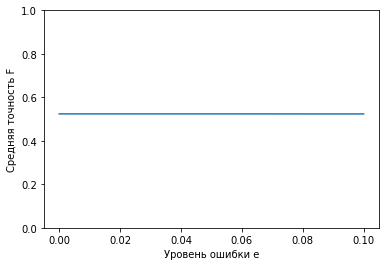

In [464]:
plt.plot(e_arr, F)
plt.xlabel("Уровень ошибки e")
plt.ylabel("Средняя точность F")
plt.ylim(0,1)

In [453]:
F

[0.5238715054060037,
 0.5238716412682316,
 0.523872562746529,
 0.5238731862740098,
 0.5238675827430654,
 0.523878187400147,
 0.523710883642415,
 0.5235486951255207]

In [272]:
phi_i = QFT(n, psi, with_noise=True, e=e_i)